# Movie data analysis between genre and profit ratio

The movie business might look pretty glamorous and lucrative.
I wanted to take a look at how the major genres perform around the world relative to their global average performance to determine which genres are the most profitable.I also think that genre is so important for any studio creating a new movie . If we investigate this data, we can to an extent understand what genre is the best for audience. I wanted to use this dataset to get a deeper understanding of profit ratio between difference genre. I will be performing ANOVA and t-test  between the genres and profit ratio.

## Part 1: Preparing data

In [10]:
#import library
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sqlite3
import seaborn as sns
import zipfile
import statsmodels.api as sm
from statsmodels.formula.api import ols
sns.set()

In [11]:
#read data
movie_budgets =pd.read_csv('C:/Users/thivnguyen/Git/Flatiron/CapStoneProject/zippedData/tn.movie_budgets.csv.gz')
zip_file = "C:/Users/thivnguyen/Git/Flatiron/CapStoneProject/zippedData/im.db.zip"

try:
    with zipfile.ZipFile(zip_file, 'r') as z:
        z.extractall("zippedData/unZippedim.db")
        print("Extracted all")
except:
    print("Invalid file")
conn = sqlite3.connect("zippedData/unZippedim.db/im.db")
##change trelease_date object type to datetime type
movie_budgets["release_date"] = pd.to_datetime(movie_budgets["release_date"])
#movie_budgets.info()\
#clean movie_budget dataset
def clean_currency(x):
    """ If the value is a string, then remove currency symbol and delimiters
    otherwise, the value is numeric and can be converted
    """
    if isinstance(x, str):
        return(x.replace('$', '').replace(',', ''))
    return(x)

movie_budgets['production_budget'] = movie_budgets['production_budget'].apply(clean_currency).astype('float64')
movie_budgets['domestic_gross'] = movie_budgets['domestic_gross'].apply(clean_currency).astype('float64')
movie_budgets['worldwide_gross'] = movie_budgets['worldwide_gross'].apply(clean_currency).astype('float64')


Extracted all


There are a lot of different factors that go into making film. You can do poorly even with all element but you have to yourself up to success a big element of that is genre. In order to camparing different genre, I use profit ratio which is calulated by suntracting profit and movie budget then dividing to movie buget. This table shows you top 5 highest profit ratio movies .

In [61]:
q1= """
SELECT * 
FROM movie_basics
INNER JOIN movie_ratings
USING("movie_id")
INNER JOIN movie_akas
USING("movie_id")
"""
sql_dataset_merge1 = pd.read_sql(q1,conn)
#find and remove duplicate rows across'movie_id', 'title', 'start_year' columns 
duplicateRows = sql_dataset_merge1[sql_dataset_merge1.duplicated(['movie_id','title', 'start_year'])]
data1= sql_dataset_merge1.drop(duplicateRows.index,axis=0)
#create new "release_year" column for merging 2 datatset
movie_budgets['release_year']= movie_budgets['release_date'].dt.year
##merge 2 dataset by using title and released year
merge_data= movie_budgets.merge(data1, how= 'inner', left_on=['movie','release_year'], right_on= ['title','start_year'])
dataset= merge_data[[ 'release_date', 'movie', 'production_budget',
       'domestic_gross', 'worldwide_gross',
       'start_year',
       'runtime_minutes', 'genres']]
#drop 7 rows with NA
dataset=dataset.dropna()
## calulate profit by subtracting gross and budget  by subtracting gross and budget domestic_gross
dataset['profit']= dataset['worldwide_gross']- dataset['production_budget']
##calulate profit ratio
dataset['profit_ratio'] = (dataset['profit'] - dataset['production_budget'])/ dataset['production_budget']

## top 5 greatest profit ratio 
dataset.sort_values(['profit_ratio'], ascending=False).head()

##this code check which movies in specific genre
#dataset[dataset['genres']. str.contains("Drama")]

,release_date,movie,production_budget,domestic_gross,worldwide_gross,start_year,runtime_minutes,genres,profit,profit_ratio
1565,2015-07-10,The Gallows,100000.0,22764410.0,41656474.0,2015,81.0,"Horror,Mystery,Thriller",41556474.0,414.564740
1465,2012-01-06,The Devil Inside,1000000.0,53262945.0,101759490.0,2012,83.0,Horror,100759490.0,99.759490
1338,2010-10-20,Paranormal Activity 2,3000000.0,84752907.0,177512032.0,2010,91.0,Horror,174512032.0,57.170677
1242,2017-02-24,Get Out,5000000.0,176040665.0,255367951.0,2017,104.0,"Horror,Mystery,Thriller",250367951.0,49.073590
1436,2016-10-21,Moonlight,1500000.0,27854931.0,65245512.0,2016,111.0,Drama,63745512.0,41.497008


The dataset contain 1581 movies after 2010. Each movie include 1 main genre or adding 2 sub-genre.After exploring dataset, I found that action movie is the most expensive genre with high budget. It makes sense because action film take longer to shot to build sequence of sence look like put people in danger to draw attention of audience. Therefore, action movie bring low profit ratio. While horror movie is low budget with high profit ratio such as The Gallow(2015), The Devil Inside(2012),...

I want to split up the genres column cells so we can tally each genre individually. Next I'll remove the 'genres' column (with multiple values) and replace it with a 'genre' column (with single values). Then I'll make sure that there is a new row for each genre, so there will be multiple rows with the same movie_title.



In [65]:

df_split_genre = dataset.copy()
# limit data to 2010-present
df_split_genre = df_split_genre.loc[df_split_genre['release_date'].dt.year >= 2010]
split_genre = df_split_genre['genres'].str.split(',').apply(pd.Series, 1).stack().reset_index(level=1, drop=True)
split_genre.name = 'genre_split'
df_split_genre = df_split_genre.drop(['genres'], axis=1).join(split_genre)
##remove outlier with only 1 movie genre which is News
df_split_genre= df_split_genre[df_split_genre['genre_split']. str.contains("News")== False]
##differrence genre in the dataset
#df_split_genre['genre_split'].unique()

## Visualize dataset

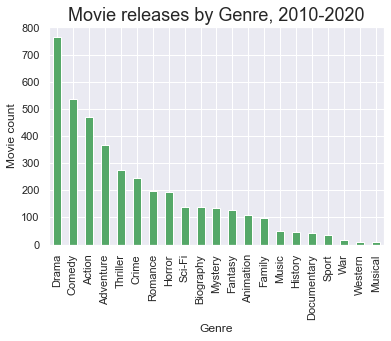

In [66]:

##histogram
df_split_genre['genre_split'].value_counts().plot(kind='bar', color='g');
plt.title('Movie releases by Genre, 2010-2019', size=18)
plt.xlabel('Genre', size=12)
plt.ylabel('Movie count', size=12);

In terms of the number of releases worldwide, dramas,comedies,action top the list between 2010 and 2019 as nearly 500 action films were released, more than 500 comedy films were released and over 700 drama films have been released.This means that the public nowadays love these kind of genres more than other. It doesn't mean that if you do that you will be sucessful because these genre require a lot of elements such as big star, high buget, so on.

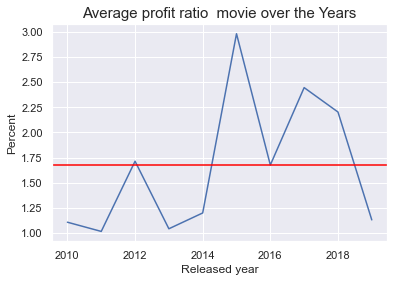

In [69]:

df_split_genre['start_year']= df_split_genre['release_date'].dt.year
gross_mean= df_split_genre.groupby(dataset['start_year'])['profit_ratio'].mean()
#print(gross_mean)
plt.plot(gross_mean)
plt.axhline(df_split_genre['profit_ratio'].mean(), color ='red')
plt.title('Average profit ratio  movie over the Years', size=15);
plt.xlabel('Released year', size=12)
plt.ylabel('Percent', size=12)
plt.legend;

We could see the average profit ratio tend to go up but the trend decrease significantly after 2018 because of the economic and covid 19. The red line show average of all profit ratio over the year which is 1.7%. This mean that it is not easy to making sucessful film making money.

## Hypothesis testing

In [1]:
#tranform data set to keep only genre and profit ratio
profit_ratio_genre=df_split_genre.groupby('genre_split')['profit_ratio'].mean().sort_values()
genre_profit=df_split_genre[['genre_split','profit_ratio']].sort_values('genre_split').reset_index(level=0, drop=True)
profit_ratio_genre=df_split_genre.groupby('genre_split')['profit_ratio'].mean().sort_values()
profit_ratio_genre.plot(kind='bar', color='y');
plt.title('Profit ratio vs Genre, 2010-2020', size=18)
plt.xlabel('Genre', size=12)
plt.ylabel('Movie count', size=12);

NameError: name 'df_split_genre' is not defined

It is clear that Mystery , Horror, Thriller is top 3 of genre with highest profit ratio. These genres have inbuild audience. This mean that as long as you have something to deliver on it for example if you do haunting movie the ghost has to be scary ot if you do thriller, the movie has to be sufficiently thrilling, the audience doesn't care a lot of actors or actress is big name or not. I would recommend, if you starting out of making films, these genres are good chance to make money. 

Next, I use one-way ANOVA to determine whether there are any statistically significant differences between the means of profit ratio in  different genres.

In [71]:


# Ordinary Least Squares (OLS) model
model = ols('profit_ratio ~ C(genre_split)', data=genre_profit).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table
# display model summary
#print(model.summary())

,sum_sq,df,F,PR(>F)
C(genre_split),12602.659279,20.0,4.192011,1.135141e-09
Residual,599767.100907,3990.0,NaN,NaN


The p value obtained from ANOVA analysis is significant (p < 0.05), and therefore, we conclude that there are significant differences among genre.

From ANOVA analysis, we know that genre differences are statistically significant, but ANOVA does not tell which genre are significantly different from each other. To know the pairs of significant different treatments, we will perform multiple pairwise comparison (post hoc comparison) analysis for all unplanned comparison using Tukey’s honestly significantly differenced (HSD) test.

Note: When the ANOVA is significant, post hoc tests are used to see differences between specific groups. post hoc tests control the family-wise error rate (inflated type I error rate) due to multiple comparisons. post hoc tests adjust the p values (Bonferroni correction) or critical value (Tukey's HSD test).

We have Tukey’s HSD test for multiple comparisons and corrects for family-wise error rate (FWER) (inflated type I error)
 
 
 Link reference:https://www.reneshbedre.com/blog/anova.html

In [72]:
# we will use bioinfokit (v1.0.3 or later) for performing tukey HSD test
# check documentation here https://github.com/reneshbedre/bioinfokit
##install bioinfokit package
from bioinfokit.analys import stat
# perform multiple pairwise comparison (Tukey's HSD)
# unequal sample size data, tukey_hsd uses Tukey-Kramer test
res = stat()
res.tukey_hsd(df=genre_profit, res_var='profit_ratio', xfac_var='genre_split', anova_model='profit_ratio ~ C(genre_split)')
##full report(if you want)
#res.tukey_summary
##filter p-value less than 0.05
res.tukey_summary[res.tukey_summary['p-value']< 0.05].sort_values('p-value')

,group1,group2,Diff,Lower,Upper,q-value,p-value
10,Action,Horror,5.963383,2.219645,9.707121,8.045882,0.001000
125,Drama,Mystery,6.153440,2.051797,10.255083,7.577859,0.001000
122,Drama,Horror,5.422917,1.894627,8.951207,7.763455,0.001000
95,Crime,Horror,6.393819,2.186790,10.600848,7.676642,0.001000
83,Comedy,Mystery,6.184147,1.954746,10.413549,7.385626,0.001000
80,Comedy,Horror,5.453624,1.777595,9.129654,7.493637,0.001000
98,Crime,Mystery,7.124342,2.426073,11.822612,7.659374,0.001000
32,Adventure,Mystery,6.227739,1.806252,10.649226,7.114567,0.001000
29,Adventure,Horror,5.497216,1.601718,9.392714,7.127976,0.001000
13,Action,Mystery,6.693906,2.405524,10.982288,7.884472,0.001000


Above results from Tukey’s HSD suggests that all other pairwise comparisons for treatments rejects null hypothesis (p < 0.05) and indicates statistical significant differences between them.

In [74]:
horror=df_split_genre[df_split_genre['genre_split'] =="Horror"]['profit_ratio']
#horror
mystery=df_split_genre[df_split_genre['genre_split'] =="Mystery"]['profit_ratio']
#mystery
import scipy.stats as stats

# #perform two sample t-test
stats.ttest_ind(a=horror, b=mystery,nan_policy='omit')

Ttest_indResult(statistic=-0.19171913020997952, pvalue=0.8480819453023514)

We see that p value greater than 0.05 so we fail to reject the null hypothesis. There is no difference of the mean profit ratio between horror and mystery.

I want to know whether or not horror movie  have the different mean profit_ratio with action movie with t-test

In [75]:
horror=df_split_genre[df_split_genre['genre_split'] =="Horror"]['profit_ratio']
#horror
action=df_split_genre[df_split_genre['genre_split'] =="Action"]['profit_ratio']
#action
stats.ttest_ind(a=horror, b=action ,nan_policy='omit')

Ttest_indResult(statistic=4.029432560755676, pvalue=6.241193309724377e-05)

We see that p value less than 0.05 so we fail to reject the null hypothesis. There is difference of the mean profit ratio between horror and action.

## Conclusion

It is clear there is  correlation between profit ration and movie genre.Top 3 genres making the most profit ratio are Mystery, Horror and Thriller.As some movie commbined 2 or 3 genres, it hard to focus only one genre. It also depend on demand of customer at particular time because the public can be fickle (changing frequently). In future, we do futher  analysis to see how to combine difference genres to maximize profit.